In [17]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
from functools import reduce
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
# suppress warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.options.display.max_columns = 150
pd.options.display.max_rows = 100

# Load Data

In [3]:
Bike_Sample = pd.read_csv('./Data/CitiBike/CitiBike_Route/Bike_Sample.csv')
Bike_Sample.head()

,SegmentID,Flow_Day_0,Flow_Day_1,Flow_Day_2,Flow_Day_3,Flow_Day_4,Flow_Day_5,Flow_Day_6,Flow_Day_7,Flow_Day_8,Flow_Day_9,Flow_Day_10,Flow_Day_11,Flow_Day_12,Flow_Day_13,Flow_Day_14,Flow_Day_15,Flow_Day_16,Flow_Day_17,Flow_Day_18,Flow_Day_19,Flow_Day_20,Flow_Day_21,Flow_Day_22,Flow_Day_23,Flow_Day_24,Flow_Day_25,Flow_Day_26,Flow_Day_27,Flow_Day_28,Flow_Day_29,Flow_Median,Flow_Mean,Flow_Total
0,78126,17,24,28,22,17,15,25,25,12,23,24,30,30,17,37,22,33,18,21,23,25,25,22,32,24,22,34,26,32,22,24,24,727
1,79796,9,42,27,20,16,21,21,20,11,17,20,19,17,33,17,28,19,25,29,21,24,20,17,32,10,15,18,14,22,26,20,21,630
2,77356,12,29,23,21,20,14,23,21,14,23,15,14,20,20,26,16,24,11,20,22,21,26,12,14,26,16,21,13,19,16,20,19,572
3,78173,38,77,59,57,53,53,63,59,47,60,65,58,71,55,80,68,77,52,47,57,61,73,56,48,49,51,68,57,73,66,58,59,1798
4,78219,9,5,7,8,8,2,4,9,9,9,6,4,10,7,9,6,3,9,3,3,6,4,3,5,2,8,5,6,8,5,6,6,182


In [4]:
Corridor_SE_sub = gpd.read_file('./Data/Corridor_SE_sub.geojson')
Corridor_SE_sub.head()

,OBJECTID,Street,StreetCode,SegmentID,SHAPE_Leng,StreetWidt,Number_Tra,Number_Par,Number_Tot,With_BikeLane,Protected_Lane,Unprotected_Lane,Truck,Manhattan,Bronx,Brooklyn,Queens,Pop,Age,MIncome,White,Bachelor_Degree,Unemployment,M_Subway,M_Bike,NoVehicle,LandUseMix,Sub_dis,geometry
0,1.0,EAST 168 STREET,226700,0078126,396.030947,34.0,2,2,4,0,0,0,0,0,1,0,0,4888.000000,32.950000,25047.000000,39.300000,81.250000,14.750000,0.304506,0.004543,0.708619,0.347640,2868.573381,"LINESTRING (1010964.447 241812.261, 1011265.49..."
1,2.0,WEST 192 STREET,274810,0079796,279.360514,30.0,1,2,3,0,0,0,0,0,1,0,0,6108.714286,34.557143,43984.285714,42.542857,83.857143,10.214286,0.482772,0.010344,0.661212,0.278651,1107.013139,"LINESTRING (1011576.687 255023.583, 1011335.15..."
2,3.0,UNION AVENUE,270420,0077356,618.327133,34.0,1,2,3,0,0,0,0,0,1,0,0,4460.166667,33.416667,32013.833333,43.933333,84.533333,10.416667,0.474371,0.005991,0.712056,0.405024,1422.213831,"LINESTRING (1011600.676 239639.743, 1011785.79..."
3,8.0,WEST 252 STREET,275175,0174633,16.897559,30.0,2,0,2,0,0,0,0,0,1,0,0,3500.000000,41.900000,118767.333333,55.633333,84.633333,4.500000,0.190216,0.005803,0.222938,0.504855,4124.926572,"LINESTRING (1009942.034 266921.538, 1009926.30..."
4,9.0,CLAREMONT PARKWAY,219720,0078173,252.183072,70.0,4,2,6,0,0,0,0,0,1,0,0,3946.500000,30.950000,35063.125000,55.037500,77.737500,12.625000,0.315259,0.002049,0.702357,0.528830,2036.358434,"LINESTRING (1010430.311 245241.982, 1010662.46..."


In [24]:
Corridor_SE_sub['SegmentID'] = Corridor_SE_sub['SegmentID'].astype(int)

In [28]:
Bike_Sample_Geo = Corridor_SE_sub.merge(Bike_Sample, on='SegmentID').to_crs(4326)

In [37]:
Bike_Sample_Geo.head()

,OBJECTID,Street,StreetCode,SegmentID,SHAPE_Leng,StreetWidt,Number_Tra,Number_Par,Number_Tot,With_BikeLane,Protected_Lane,Unprotected_Lane,Truck,Manhattan,Bronx,Brooklyn,Queens,Pop,Age,MIncome,White,Bachelor_Degree,Unemployment,M_Subway,M_Bike,NoVehicle,LandUseMix,Sub_dis,geometry,Flow_Day_0,Flow_Day_1,Flow_Day_2,Flow_Day_3,Flow_Day_4,Flow_Day_5,Flow_Day_6,Flow_Day_7,Flow_Day_8,Flow_Day_9,Flow_Day_10,Flow_Day_11,Flow_Day_12,Flow_Day_13,Flow_Day_14,Flow_Day_15,Flow_Day_16,Flow_Day_17,Flow_Day_18,Flow_Day_19,Flow_Day_20,Flow_Day_21,Flow_Day_22,Flow_Day_23,Flow_Day_24,Flow_Day_25,Flow_Day_26,Flow_Day_27,Flow_Day_28,Flow_Day_29,Flow_Median,Flow_Mean,Flow_Total
0,1.0,EAST 168 STREET,226700,78126,396.030947,34.0,2,2,4,0,0,0,0,0,1,0,0,4888.000000,32.950000,25047.000000,39.300000,81.250000,14.750000,0.304506,0.004543,0.708619,0.347640,2868.573381,"LINESTRING (-73.90347 40.83035, -73.90238 40.8...",17,24,28,22,17,15,25,25,12,23,24,30,30,17,37,22,33,18,21,23,25,25,22,32,24,22,34,26,32,22,24,24,727
1,2.0,WEST 192 STREET,274810,79796,279.360514,30.0,1,2,3,0,0,0,0,0,1,0,0,6108.714286,34.557143,43984.285714,42.542857,83.857143,10.214286,0.482772,0.010344,0.661212,0.278651,1107.013139,"LINESTRING (-73.90120 40.86661, -73.90207 40.8...",9,42,27,20,16,21,21,20,11,17,20,19,17,33,17,28,19,25,29,21,24,20,17,32,10,15,18,14,22,26,20,21,630
2,3.0,UNION AVENUE,270420,77356,618.327133,34.0,1,2,3,0,0,0,0,0,1,0,0,4460.166667,33.416667,32013.833333,43.933333,84.533333,10.416667,0.474371,0.005991,0.712056,0.405024,1422.213831,"LINESTRING (-73.90118 40.82439, -73.90051 40.8...",12,29,23,21,20,14,23,21,14,23,15,14,20,20,26,16,24,11,20,22,21,26,12,14,26,16,21,13,19,16,20,19,572
3,9.0,CLAREMONT PARKWAY,219720,78173,252.183072,70.0,4,2,6,0,0,0,0,0,1,0,0,3946.500000,30.950000,35063.125000,55.037500,77.737500,12.625000,0.315259,0.002049,0.702357,0.528830,2036.358434,"LINESTRING (-73.90538 40.83977, -73.90454 40.8...",38,77,59,57,53,53,63,59,47,60,65,58,71,55,80,68,77,52,47,57,61,73,56,48,49,51,68,57,73,66,58,59,1798
4,10.0,TOPPING AVENUE,269220,78219,291.757016,28.0,1,2,3,0,0,0,0,0,1,0,0,4280.250000,32.512500,32992.500000,45.162500,82.375000,11.075000,0.442476,0.002049,0.740004,0.397029,879.454344,"LINESTRING (-73.90559 40.84669, -73.90552 40.8...",9,5,7,8,8,2,4,9,9,9,6,4,10,7,9,6,3,9,3,3,6,4,3,5,2,8,5,6,8,5,6,6,182


In [30]:
Bike_Sample_Geo.to_file('./Data/Model/Bike_Sample_Geo.geojson', driver='GeoJSON')

In [38]:
ct2010 = gpd.read_file('./Data/GeoBase/ct2010_geoid.geojson')

<AxesSubplot:>

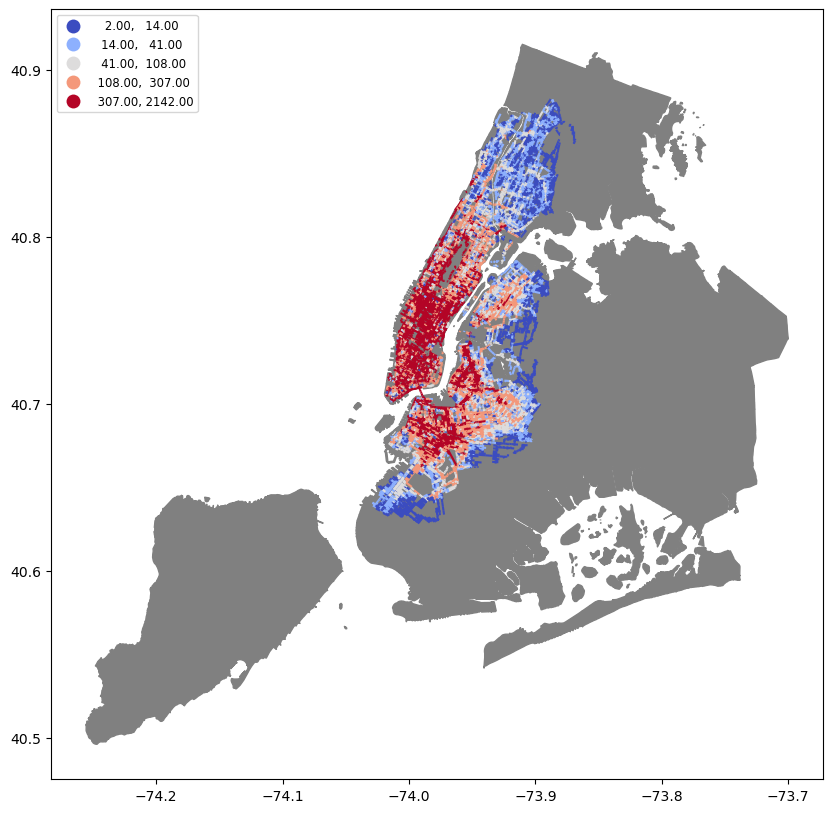

In [41]:
ax = ct2010.to_crs(4326).plot(figsize=(10,10), facecolor='grey', edgecolor='grey')
Bike_Sample_Geo.plot(column='Flow_Median', k=5, scheme='Quantiles',cmap='coolwarm',
                                             legend=True, legend_kwds={'loc':'upper left','fontsize':'small'}
                                             ,ax=ax)

# Train Model

In [56]:
# merge data

df_x = Corridor_SE_sub[['SegmentID','StreetWidt', 'Number_Tra', 'Number_Par', 'Number_Tot', 'With_BikeLane',
       'Protected_Lane', 'Unprotected_Lane', 'Truck', 'Manhattan', 'Bronx',
       'Brooklyn', 'Queens', 'Pop', 'Age', 'MIncome', 'White',
       'Bachelor_Degree', 'Unemployment', 'M_Subway', 'M_Bike', 'NoVehicle',
       'LandUseMix', 'Sub_dis']]

df_x.head()

,SegmentID,StreetWidt,Number_Tra,Number_Par,Number_Tot,With_BikeLane,Protected_Lane,Unprotected_Lane,Truck,Manhattan,Bronx,Brooklyn,Queens,Pop,Age,MIncome,White,Bachelor_Degree,Unemployment,M_Subway,M_Bike,NoVehicle,LandUseMix,Sub_dis
0,78126,34.0,2,2,4,0,0,0,0,0,1,0,0,4888.000000,32.950000,25047.000000,39.300000,81.250000,14.750000,0.304506,0.004543,0.708619,0.347640,2868.573381
1,79796,30.0,1,2,3,0,0,0,0,0,1,0,0,6108.714286,34.557143,43984.285714,42.542857,83.857143,10.214286,0.482772,0.010344,0.661212,0.278651,1107.013139
2,77356,34.0,1,2,3,0,0,0,0,0,1,0,0,4460.166667,33.416667,32013.833333,43.933333,84.533333,10.416667,0.474371,0.005991,0.712056,0.405024,1422.213831
3,174633,30.0,2,0,2,0,0,0,0,0,1,0,0,3500.000000,41.900000,118767.333333,55.633333,84.633333,4.500000,0.190216,0.005803,0.222938,0.504855,4124.926572
4,78173,70.0,4,2,6,0,0,0,0,0,1,0,0,3946.500000,30.950000,35063.125000,55.037500,77.737500,12.625000,0.315259,0.002049,0.702357,0.528830,2036.358434


In [57]:
df = df_x.merge(Bike_Sample[['SegmentID','Flow_Median']], on='SegmentID').reset_index(drop=True)
df

,SegmentID,StreetWidt,Number_Tra,Number_Par,Number_Tot,With_BikeLane,Protected_Lane,Unprotected_Lane,Truck,Manhattan,Bronx,Brooklyn,Queens,Pop,Age,MIncome,White,Bachelor_Degree,Unemployment,M_Subway,M_Bike,NoVehicle,LandUseMix,Sub_dis,Flow_Median
0,78126,34.0,2,2,4,0,0,0,0,0,1,0,0,4888.000000,32.950000,25047.000000,39.300000,81.250000,14.750000,0.304506,0.004543,0.708619,0.347640,2868.573381,24
1,79796,30.0,1,2,3,0,0,0,0,0,1,0,0,6108.714286,34.557143,43984.285714,42.542857,83.857143,10.214286,0.482772,0.010344,0.661212,0.278651,1107.013139,20
2,77356,34.0,1,2,3,0,0,0,0,0,1,0,0,4460.166667,33.416667,32013.833333,43.933333,84.533333,10.416667,0.474371,0.005991,0.712056,0.405024,1422.213831,20
3,78173,70.0,4,2,6,0,0,0,0,0,1,0,0,3946.500000,30.950000,35063.125000,55.037500,77.737500,12.625000,0.315259,0.002049,0.702357,0.528830,2036.358434,58
4,78219,28.0,1,2,3,0,0,0,0,0,1,0,0,4280.250000,32.512500,32992.500000,45.162500,82.375000,11.075000,0.442476,0.002049,0.740004,0.397029,879.454344,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27768,323603,45.0,2,2,4,1,0,1,1,0,0,0,1,2878.400000,36.720000,53709.200000,54.720000,79.260000,5.260000,0.471223,0.039353,0.630075,0.517070,2795.255760,122
27769,323605,45.0,2,2,4,1,0,1,1,0,0,0,1,2878.400000,36.720000,53709.200000,54.720000,79.260000,5.260000,0.471223,0.039353,0.630075,0.517070,2753.451704,122
27770,323606,45.0,2,2,4,1,0,1,1,0,0,0,1,2878.400000,36.720000,53709.200000,54.720000,79.260000,5.260000,0.471223,0.039353,0.630075,0.517070,2322.709491,103
27771,323693,26.0,2,1,3,0,0,0,0,0,0,0,1,3353.800000,38.840000,80798.600000,69.860000,88.400000,4.520000,0.587802,0.025097,0.504432,0.366902,2884.328208,14


[2, 1]
[4, 1]
[4, 2]
[4, 3]
[7, 5]
[11, 9]
[13, 9]
[15, 10]
[16, 10]
[16, 15]
[17, 16]
[18, 10]
[18, 15]
[18, 16]
[18, 17]
[21, 9]
[21, 12]
[22, 15]


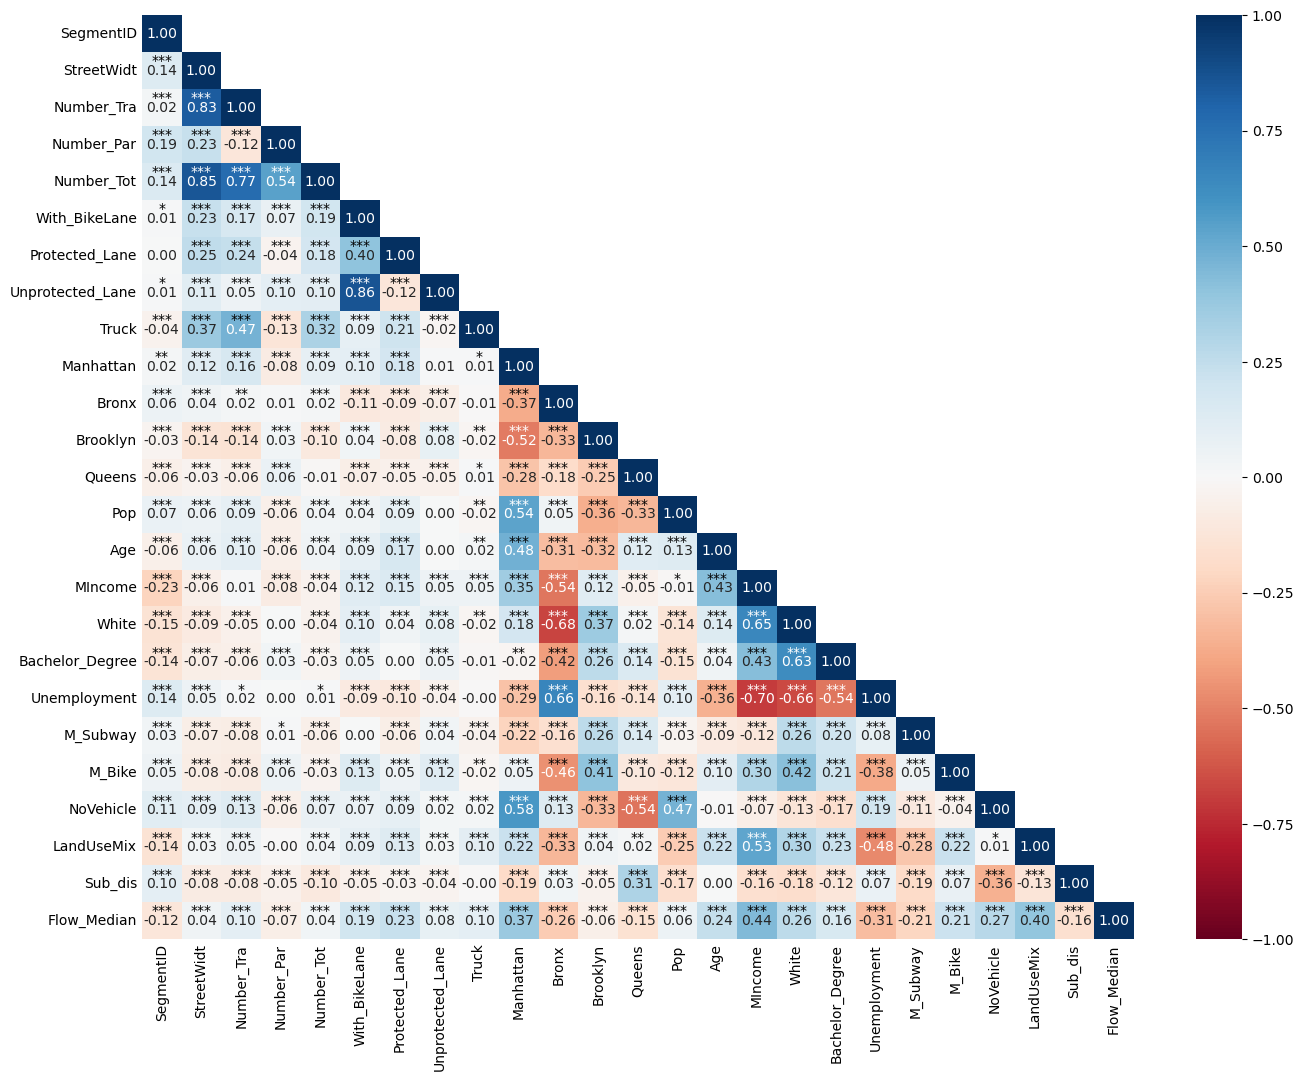

In [58]:
df_coor=df.corr() 
fig = plt.figure(figsize=(16,12))
ax1 = plt.gca()


mask = np.zeros_like(df_coor)
mask[np.triu_indices_from(mask)] = True
mask2 = mask
mask = (np.flipud(mask)-1)*(-1)
mask = np.rot90(mask,k = -1)

im1 = sns.heatmap(df_coor,annot=True,cmap="RdBu"
, mask=mask # triangle format
,vmax=1,vmin=-1
, fmt='.2f',ax = ax1)

ax1.tick_params(axis = 'both', length=0)

# calculate P-value
df = df
rlist = []
plist = []
for i in df.columns.values:
    for j in df.columns.values:
        r,p = pearsonr(df[i],df[j])
        rlist.append(r)
        plist.append(p)

rarr = np.asarray(rlist).reshape(len(df.columns.values),len(df.columns.values))
parr = np.asarray(plist).reshape(len(df.columns.values),len(df.columns.values))
xlist = ax1.get_xticks()
ylist = ax1.get_yticks()

widthx = 0
widthy = -0.15

for m in ax1.get_xticks():
    for n in ax1.get_yticks():
        pv = (parr[int(m),int(n)])
        rv = (rarr[int(m),int(n)])
        if mask2[int(m),int(n)]<1.:
            if abs(rv) > 0.5:
                if  pv< 0.05 and pv>= 0.01:
                    ax1.text(n+widthx,m+widthy,'*',ha = 'center',color = 'white')
                if  pv< 0.01 and pv>= 0.001:
                    ax1.text(n+widthx,m+widthy,'**',ha = 'center',color = 'white')
                if  pv< 0.001:
                    print([int(m),int(n)])
                    ax1.text(n+widthx,m+widthy,'***',ha = 'center',color = 'white')
            else: 
                if  pv< 0.05 and pv>= 0.01:
                    ax1.text(n+widthx,m+widthy,'*',ha = 'center',color = 'k')
                elif  pv< 0.01 and pv>= 0.001:
                    ax1.text(n+widthx,m+widthy,'**',ha = 'center',color = 'k')
                elif  pv< 0.001:
                    ax1.text(n+widthx,m+widthy,'***',ha = 'center',color = 'k')
#plt.savefig(r'Z:\GJ\pearsonr\fig\r_demo.png',dpi=600)
plt.show()

## Random Forest

In [64]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import graphviz
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [65]:
y=df['Flow_Median']
x=df.iloc[:,1:-1]

In [67]:
x.head()

,StreetWidt,Number_Tra,Number_Par,Number_Tot,With_BikeLane,Protected_Lane,Unprotected_Lane,Truck,Manhattan,Bronx,Brooklyn,Queens,Pop,Age,MIncome,White,Bachelor_Degree,Unemployment,M_Subway,M_Bike,NoVehicle,LandUseMix,Sub_dis
0,34.0,2,2,4,0,0,0,0,0,1,0,0,4888.000000,32.950000,25047.000000,39.300000,81.250000,14.750000,0.304506,0.004543,0.708619,0.347640,2868.573381
1,30.0,1,2,3,0,0,0,0,0,1,0,0,6108.714286,34.557143,43984.285714,42.542857,83.857143,10.214286,0.482772,0.010344,0.661212,0.278651,1107.013139
2,34.0,1,2,3,0,0,0,0,0,1,0,0,4460.166667,33.416667,32013.833333,43.933333,84.533333,10.416667,0.474371,0.005991,0.712056,0.405024,1422.213831
3,70.0,4,2,6,0,0,0,0,0,1,0,0,3946.500000,30.950000,35063.125000,55.037500,77.737500,12.625000,0.315259,0.002049,0.702357,0.528830,2036.358434
4,28.0,1,2,3,0,0,0,0,0,1,0,0,4280.250000,32.512500,32992.500000,45.162500,82.375000,11.075000,0.442476,0.002049,0.740004,0.397029,879.454344


### 1. Tunning n_estimators

0.4445469228130853 0    801
Name: N_estimator, dtype: int64


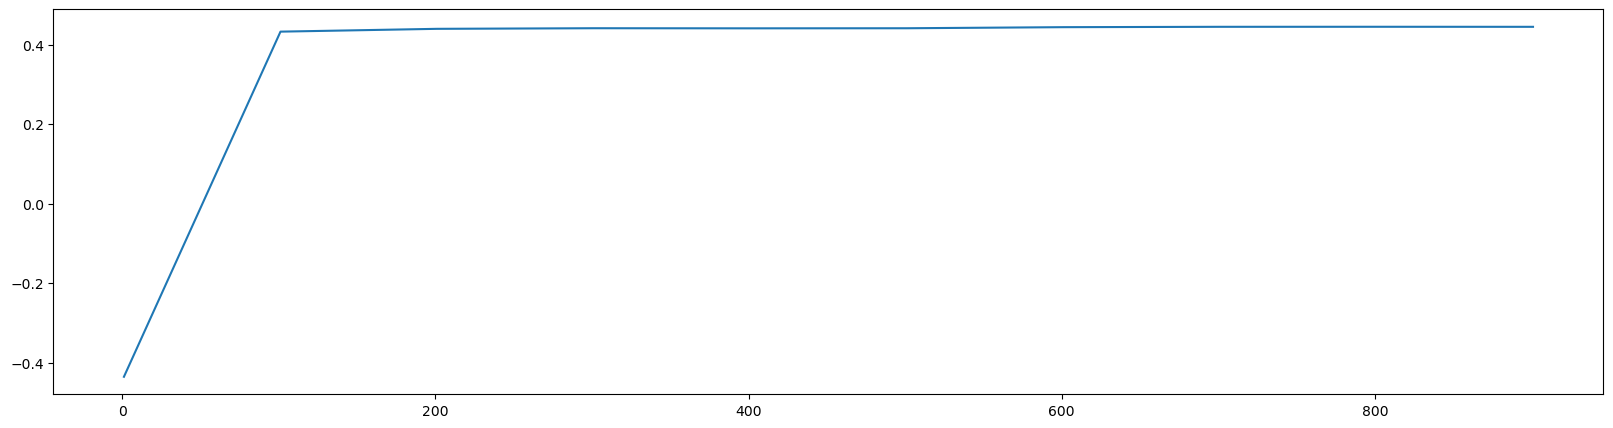

In [69]:
import time

scorel = pd.DataFrame()

start_time = time.time()

for i in range(1,1001,100):
    rfs = RandomForestRegressor(n_estimators=i,
    n_jobs=-1,
    random_state=90)

    score = cross_val_score(rfs,x,y,cv=10).mean()
    scorel = scorel.append(pd.DataFrame({'N_estimator':[i], 'Score':[score]}))
    
    if i%10 == 0: 
        end_time = time.time()
        print(int((end_time-start_time)/60),'min')
    
print(max(scorel.Score), scorel.loc[scorel.Score == max(scorel.Score),'N_estimator'])
plt.figure(figsize=[20,5])
plt.plot(range(1,1001,100), scorel.Score)
plt.show()

3 min
20 min
39 min
59 min
0.44482262982637844 0    830
Name: N_estimator, dtype: int64


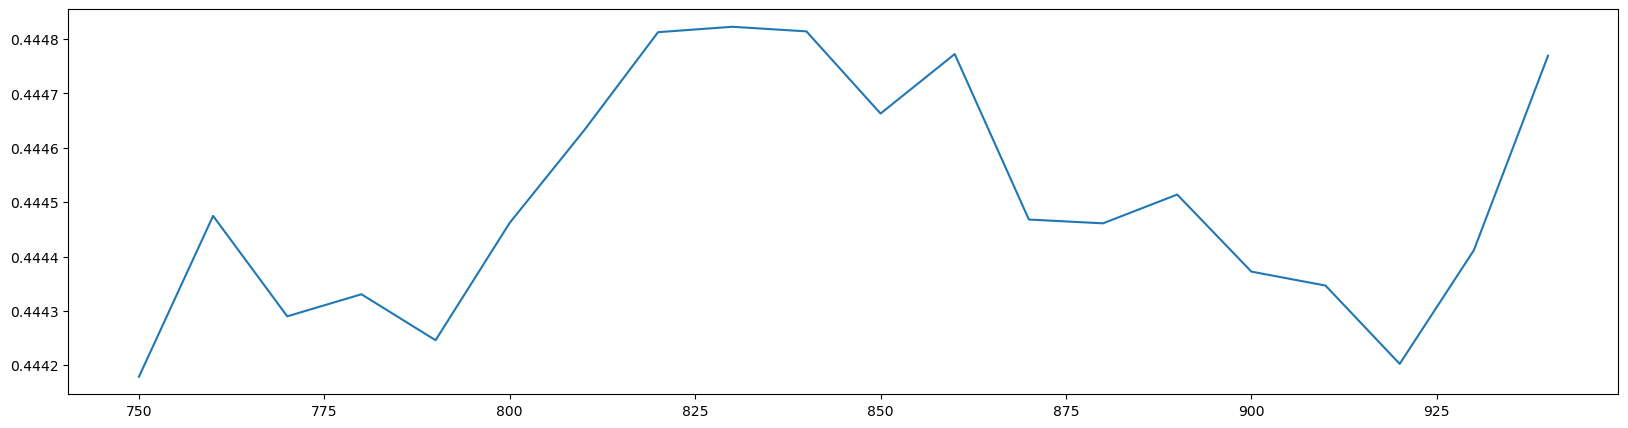

In [76]:
scorel = pd.DataFrame()

start_time = time.time()

for i in range(750,950,10):
    rfs = RandomForestRegressor(n_estimators=i,
    n_jobs=-1,
    random_state=90)

    score = cross_val_score(rfs,x,y,cv=10).mean()
    scorel = scorel.append(pd.DataFrame({'N_estimator':[i], 'Score':[score]}))
    
    if i%50 == 0: 
        end_time = time.time()
        print(int((end_time-start_time)/60),'min')
    
print(max(scorel.Score), scorel.loc[scorel.Score == max(scorel.Score),'N_estimator'])
plt.figure(figsize=[20,5])
plt.plot(range(750,950,10), scorel.Score)
plt.show()

### 2. Tunning max_depth

2 min
43 min
0.4463034653120429 0    31
Name: N_estimator, dtype: int64


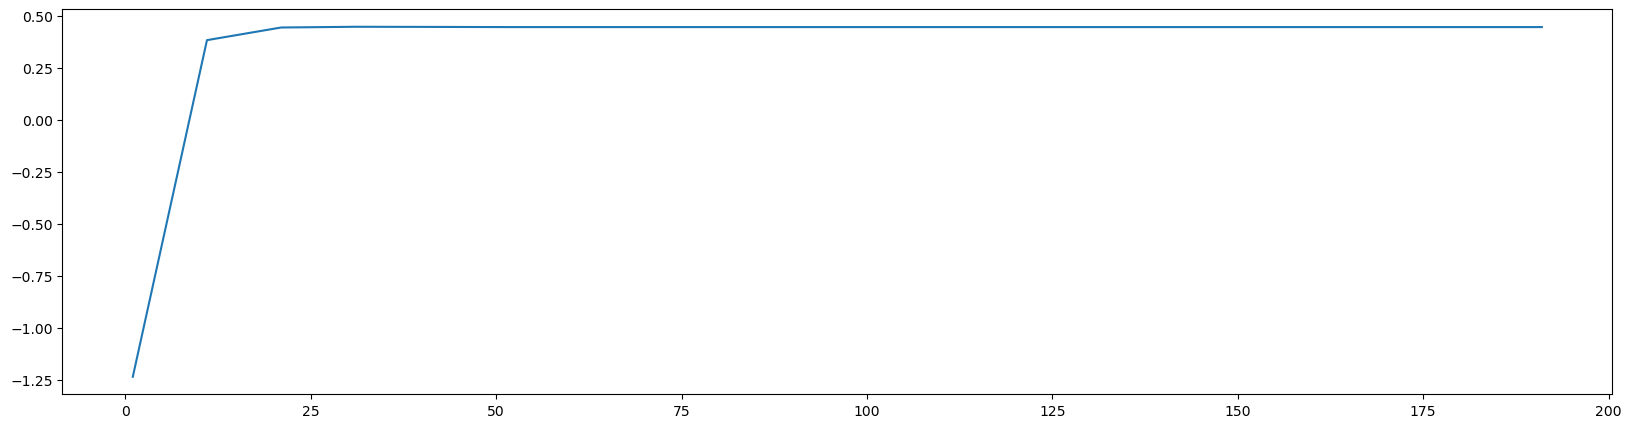

In [82]:
scorel = pd.DataFrame()

start_time = time.time()

for i in range(1,201,10):
    rfs = RandomForestRegressor(n_estimators=830,
                                max_depth=i,
                                n_jobs=-1,
                                random_state=90)

    score = cross_val_score(rfs,x,y,cv=10).mean()
    scorel = scorel.append(pd.DataFrame({'N_estimator':[i], 'Score':[score]}))
    
    if i%11 == 0: 
        end_time = time.time()
        print(int((end_time-start_time)/60),'min')
    
print(max(scorel.Score), scorel.loc[scorel.Score == max(scorel.Score),'N_estimator'])
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10), scorel.Score)
plt.show()

3 min
21 min
0.4470453466190548 0    28
Name: N_estimator, dtype: int64


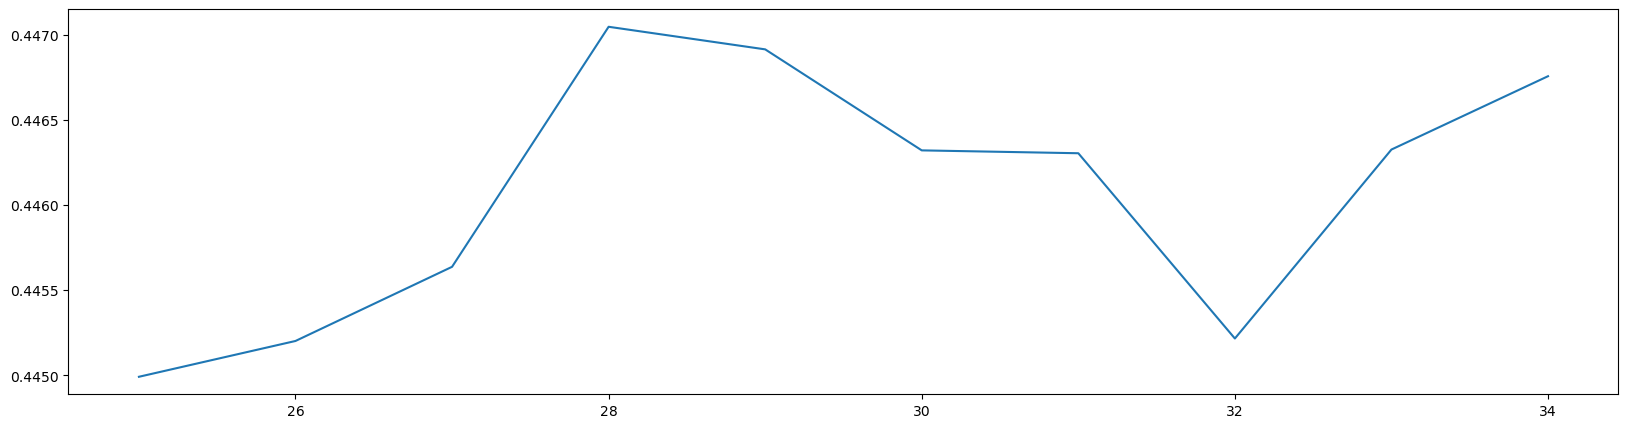

In [84]:
scorel = pd.DataFrame()

start_time = time.time()

for i in range(25,35,1):
    rfs = RandomForestRegressor(n_estimators=830,
                                max_depth=i,
                                n_jobs=-1,
                                random_state=90)

    score = cross_val_score(rfs,x,y,cv=10).mean()
    scorel = scorel.append(pd.DataFrame({'N_estimator':[i], 'Score':[score]}))
    
    if i%5 == 0: 
        end_time = time.time()
        print(int((end_time-start_time)/60),'min')
    
print(max(scorel.Score), scorel.loc[scorel.Score == max(scorel.Score),'N_estimator'])
plt.figure(figsize=[20,5])
plt.plot(range(25,35,1), scorel.Score)
plt.show()

### 3. Tunning min_samples_split

3 min
10 min
17 min
24 min
30 min
37 min
43 min
49 min
55 min
61 min
0.4475383489102949 0    3
Name: N_estimator, dtype: int64


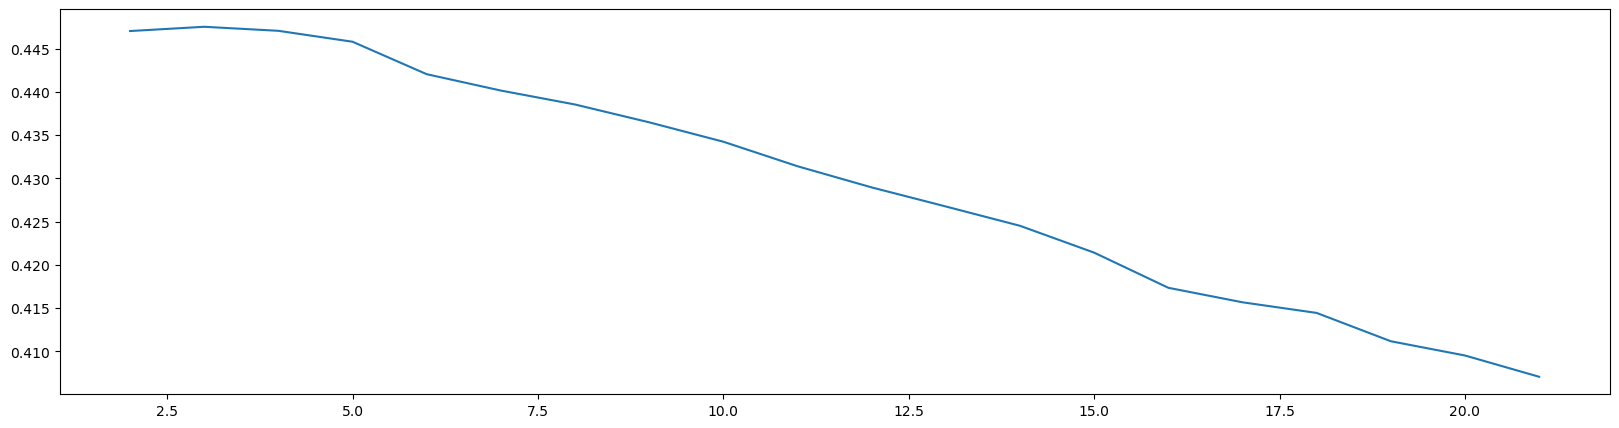

In [85]:
scorel = pd.DataFrame()

start_time = time.time()

for i in range(2,22,1):
    rfs = RandomForestRegressor(n_estimators=830,
                                max_depth=28,
                                min_samples_split=i,
                                n_jobs=-1,
                                random_state=90)

    score = cross_val_score(rfs,x,y,cv=10).mean()
    scorel = scorel.append(pd.DataFrame({'N_estimator':[i], 'Score':[score]}))
    
    if i%2 == 0: 
        end_time = time.time()
        print(int((end_time-start_time)/60),'min')
    
print(max(scorel.Score), scorel.loc[scorel.Score == max(scorel.Score),'N_estimator'])
plt.figure(figsize=[20,5])
plt.plot(range(2,22,1), scorel.Score)
plt.show()

### 4. Tunning min_samples_leaf

6 min
12 min
18 min
23 min
29 min
0.45021832682457363 0    2
Name: N_estimator, dtype: int64


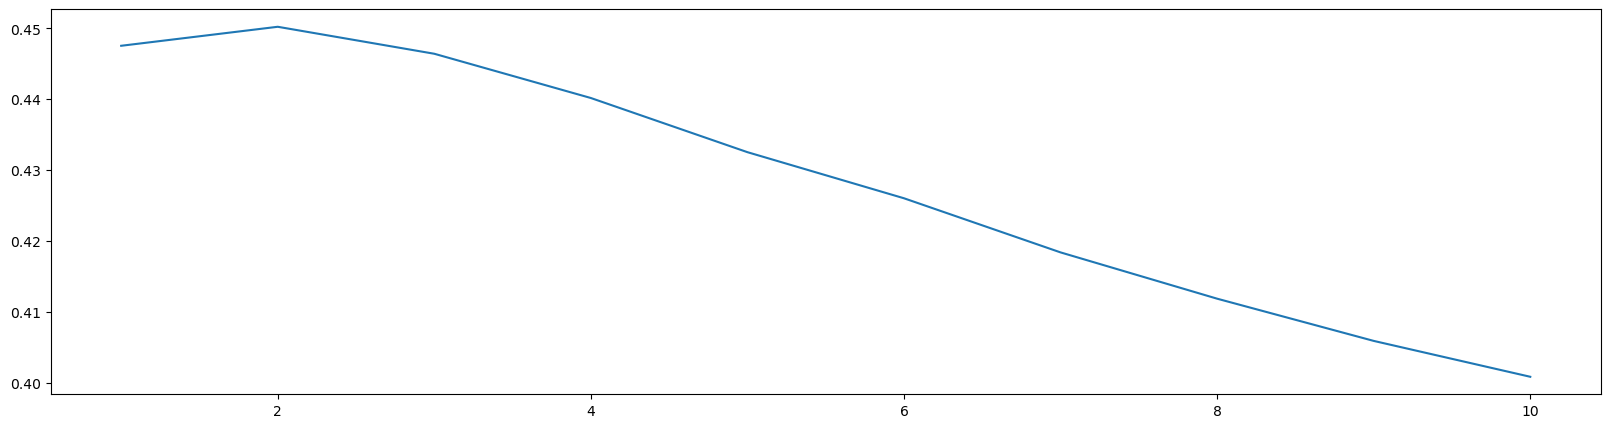

In [86]:
scorel = pd.DataFrame()

start_time = time.time()

for i in range(1,11,1):
    rfs = RandomForestRegressor(n_estimators=830,
                                max_depth=28,
                                min_samples_split=3,
                                min_samples_leaf=i,
                                n_jobs=-1,
                                random_state=90)

    score = cross_val_score(rfs,x,y,cv=10).mean()
    scorel = scorel.append(pd.DataFrame({'N_estimator':[i], 'Score':[score]}))
    
    if i%2 == 0: 
        end_time = time.time()
        print(int((end_time-start_time)/60),'min')
    
print(max(scorel.Score), scorel.loc[scorel.Score == max(scorel.Score),'N_estimator'])
plt.figure(figsize=[20,5])
plt.plot(range(1,11,1), scorel.Score)
plt.show()

### 5. Tunning max_features

2 min
4 min
8 min
12 min
16 min
20 min
26 min
32 min
0.49448870606638895 0    7
Name: N_estimator, dtype: int64


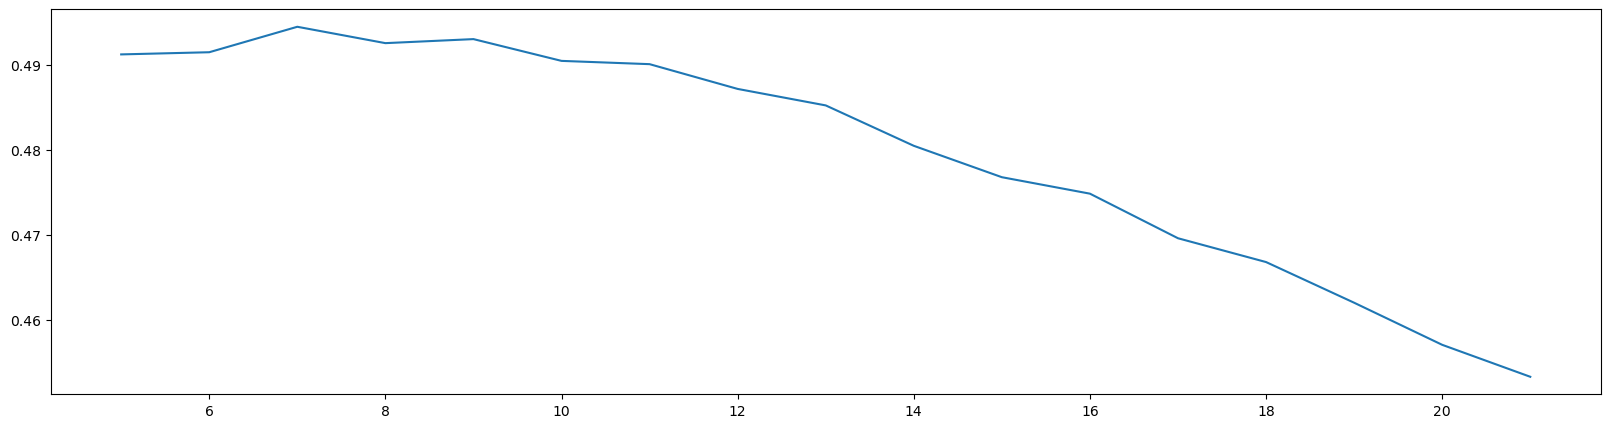

In [88]:
scorel = pd.DataFrame()

start_time = time.time()

for i in range(5,22,1):
    rfs = RandomForestRegressor(n_estimators=830,
                                max_depth=28,
                                min_samples_split=3,
                                min_samples_leaf=2,
                                max_features=i,
                                n_jobs=-1,
                                random_state=90)

    score = cross_val_score(rfs,x,y,cv=10).mean()
    scorel = scorel.append(pd.DataFrame({'N_estimator':[i], 'Score':[score]}))
    
    if i%2 == 0: 
        end_time = time.time()
        print(int((end_time-start_time)/60),'min')
    
print(max(scorel.Score), scorel.loc[scorel.Score == max(scorel.Score),'N_estimator'])
plt.figure(figsize=[20,5])
plt.plot(range(5,22,1), scorel.Score)
plt.show()

## Final Model

In [97]:
rfs = RandomForestRegressor(n_estimators=830,
                                max_depth=28,
                                min_samples_split=3,
                                min_samples_leaf=2,
                                max_features=7,
                                n_jobs=-1,
                                random_state=90)

score = cross_val_score(rfs,x,y,cv=10).mean()
print(score)

0.49448870606638895


In [99]:
rfs = RandomForestRegressor(n_estimators=830,
                                max_depth=28,
                                min_samples_split=3,
                                min_samples_leaf=2,
                                max_features=7,
                                n_jobs=-1,
                                random_state=90).fit(x,y)

In [100]:
feature_imp = pd.DataFrame({'name':x.columns, 'value':rfs.feature_importances_}).sort_values(by='value',ascending=True)
feature_imp

,name,value
11,Queens,0.002688
9,Bronx,0.005732
6,Unprotected_Lane,0.006016
10,Brooklyn,0.006343
7,Truck,0.007153
1,Number_Tra,0.011127
2,Number_Par,0.012434
4,With_BikeLane,0.012933
5,Protected_Lane,0.016387
3,Number_Tot,0.021089


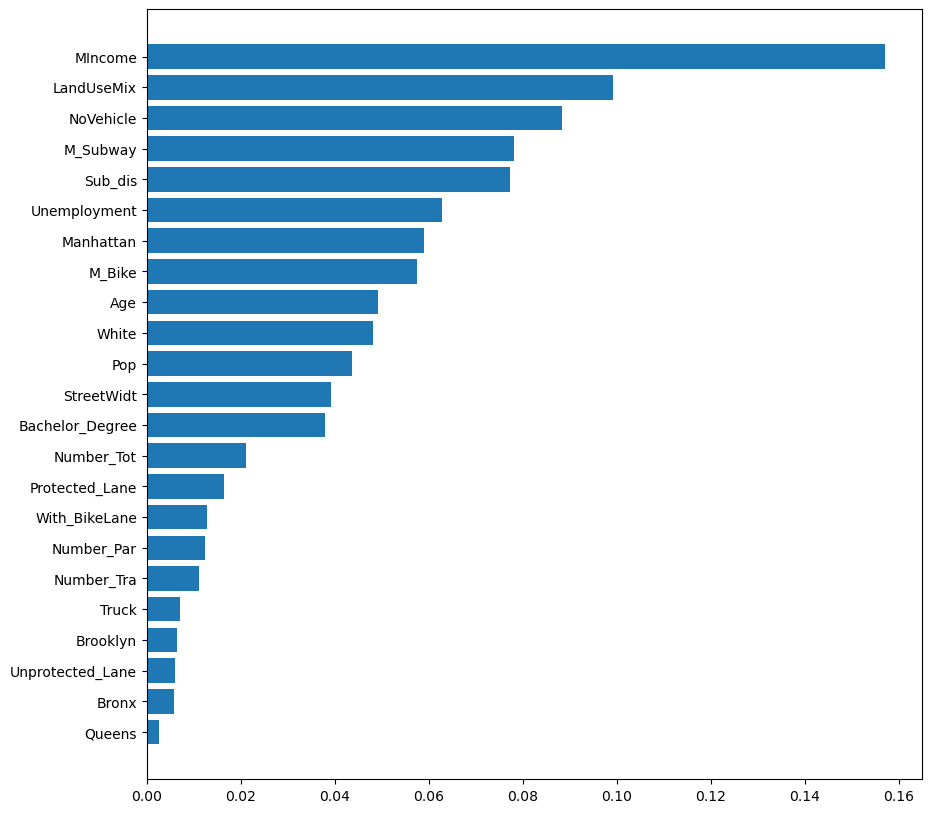

In [101]:
plot, ax = plt.subplots(1,1,figsize = (10,10))
plt.barh(feature_imp.name, feature_imp.value)
plt.show()

In [102]:
y_predict = rfs.predict(x)

In [103]:
y_predict

array([20.73376995, 18.09270391, 16.89949991, ..., 93.56987699,
       16.42678084, 21.97284469])

In [ ]:
import shap
Explainer = shap.TreeExplainer(rfs)
shap_values = Explainer.shap_values(x)
shap.summary_plot(shap_values, x, color_bar=True)

### MAE

In [106]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [107]:
mae(y,y_predict)

54.533113290210714

In [108]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
sqrt(mean_squared_error(y, y_predict)) 

111.20809048164722

### Save Prediction Data

In [120]:
Bike_Predict_Geo = Bike_Sample_Geo.copy()
Bike_Predict_Geo['Flow_Median_predict'] = y_predict.astype(int)
Bike_Predict_Geo.head()

,OBJECTID,Street,StreetCode,SegmentID,SHAPE_Leng,StreetWidt,Number_Tra,Number_Par,Number_Tot,With_BikeLane,Protected_Lane,Unprotected_Lane,Truck,Manhattan,Bronx,Brooklyn,Queens,Pop,Age,MIncome,White,Bachelor_Degree,Unemployment,M_Subway,M_Bike,NoVehicle,LandUseMix,Sub_dis,geometry,Flow_Day_0,Flow_Day_1,Flow_Day_2,Flow_Day_3,Flow_Day_4,Flow_Day_5,Flow_Day_6,Flow_Day_7,Flow_Day_8,Flow_Day_9,Flow_Day_10,Flow_Day_11,Flow_Day_12,Flow_Day_13,Flow_Day_14,Flow_Day_15,Flow_Day_16,Flow_Day_17,Flow_Day_18,Flow_Day_19,Flow_Day_20,Flow_Day_21,Flow_Day_22,Flow_Day_23,Flow_Day_24,Flow_Day_25,Flow_Day_26,Flow_Day_27,Flow_Day_28,Flow_Day_29,Flow_Median,Flow_Mean,Flow_Total,Flow_Median_predict
0,1.0,EAST 168 STREET,226700,78126,396.030947,34.0,2,2,4,0,0,0,0,0,1,0,0,4888.000000,32.950000,25047.000000,39.300000,81.250000,14.750000,0.304506,0.004543,0.708619,0.347640,2868.573381,"LINESTRING (-73.90347 40.83035, -73.90238 40.8...",17,24,28,22,17,15,25,25,12,23,24,30,30,17,37,22,33,18,21,23,25,25,22,32,24,22,34,26,32,22,24,24,727,20
1,2.0,WEST 192 STREET,274810,79796,279.360514,30.0,1,2,3,0,0,0,0,0,1,0,0,6108.714286,34.557143,43984.285714,42.542857,83.857143,10.214286,0.482772,0.010344,0.661212,0.278651,1107.013139,"LINESTRING (-73.90120 40.86661, -73.90207 40.8...",9,42,27,20,16,21,21,20,11,17,20,19,17,33,17,28,19,25,29,21,24,20,17,32,10,15,18,14,22,26,20,21,630,18
2,3.0,UNION AVENUE,270420,77356,618.327133,34.0,1,2,3,0,0,0,0,0,1,0,0,4460.166667,33.416667,32013.833333,43.933333,84.533333,10.416667,0.474371,0.005991,0.712056,0.405024,1422.213831,"LINESTRING (-73.90118 40.82439, -73.90051 40.8...",12,29,23,21,20,14,23,21,14,23,15,14,20,20,26,16,24,11,20,22,21,26,12,14,26,16,21,13,19,16,20,19,572,16
3,9.0,CLAREMONT PARKWAY,219720,78173,252.183072,70.0,4,2,6,0,0,0,0,0,1,0,0,3946.500000,30.950000,35063.125000,55.037500,77.737500,12.625000,0.315259,0.002049,0.702357,0.528830,2036.358434,"LINESTRING (-73.90538 40.83977, -73.90454 40.8...",38,77,59,57,53,53,63,59,47,60,65,58,71,55,80,68,77,52,47,57,61,73,56,48,49,51,68,57,73,66,58,59,1798,43
4,10.0,TOPPING AVENUE,269220,78219,291.757016,28.0,1,2,3,0,0,0,0,0,1,0,0,4280.250000,32.512500,32992.500000,45.162500,82.375000,11.075000,0.442476,0.002049,0.740004,0.397029,879.454344,"LINESTRING (-73.90559 40.84669, -73.90552 40.8...",9,5,7,8,8,2,4,9,9,9,6,4,10,7,9,6,3,9,3,3,6,4,3,5,2,8,5,6,8,5,6,6,182,10


In [121]:
Bike_Predict_Geo['Error_abs'] = abs(Bike_Predict_Geo['Flow_Median'] - Bike_Predict_Geo['Flow_Median_predict']).astype(int)
Bike_Predict_Geo.head()

,OBJECTID,Street,StreetCode,SegmentID,SHAPE_Leng,StreetWidt,Number_Tra,Number_Par,Number_Tot,With_BikeLane,Protected_Lane,Unprotected_Lane,Truck,Manhattan,Bronx,Brooklyn,Queens,Pop,Age,MIncome,White,Bachelor_Degree,Unemployment,M_Subway,M_Bike,NoVehicle,LandUseMix,Sub_dis,geometry,Flow_Day_0,Flow_Day_1,Flow_Day_2,Flow_Day_3,Flow_Day_4,Flow_Day_5,Flow_Day_6,Flow_Day_7,Flow_Day_8,Flow_Day_9,Flow_Day_10,Flow_Day_11,Flow_Day_12,Flow_Day_13,Flow_Day_14,Flow_Day_15,Flow_Day_16,Flow_Day_17,Flow_Day_18,Flow_Day_19,Flow_Day_20,Flow_Day_21,Flow_Day_22,Flow_Day_23,Flow_Day_24,Flow_Day_25,Flow_Day_26,Flow_Day_27,Flow_Day_28,Flow_Day_29,Flow_Median,Flow_Mean,Flow_Total,Flow_Median_predict,Error_abs
0,1.0,EAST 168 STREET,226700,78126,396.030947,34.0,2,2,4,0,0,0,0,0,1,0,0,4888.000000,32.950000,25047.000000,39.300000,81.250000,14.750000,0.304506,0.004543,0.708619,0.347640,2868.573381,"LINESTRING (-73.90347 40.83035, -73.90238 40.8...",17,24,28,22,17,15,25,25,12,23,24,30,30,17,37,22,33,18,21,23,25,25,22,32,24,22,34,26,32,22,24,24,727,20,4
1,2.0,WEST 192 STREET,274810,79796,279.360514,30.0,1,2,3,0,0,0,0,0,1,0,0,6108.714286,34.557143,43984.285714,42.542857,83.857143,10.214286,0.482772,0.010344,0.661212,0.278651,1107.013139,"LINESTRING (-73.90120 40.86661, -73.90207 40.8...",9,42,27,20,16,21,21,20,11,17,20,19,17,33,17,28,19,25,29,21,24,20,17,32,10,15,18,14,22,26,20,21,630,18,2
2,3.0,UNION AVENUE,270420,77356,618.327133,34.0,1,2,3,0,0,0,0,0,1,0,0,4460.166667,33.416667,32013.833333,43.933333,84.533333,10.416667,0.474371,0.005991,0.712056,0.405024,1422.213831,"LINESTRING (-73.90118 40.82439, -73.90051 40.8...",12,29,23,21,20,14,23,21,14,23,15,14,20,20,26,16,24,11,20,22,21,26,12,14,26,16,21,13,19,16,20,19,572,16,4
3,9.0,CLAREMONT PARKWAY,219720,78173,252.183072,70.0,4,2,6,0,0,0,0,0,1,0,0,3946.500000,30.950000,35063.125000,55.037500,77.737500,12.625000,0.315259,0.002049,0.702357,0.528830,2036.358434,"LINESTRING (-73.90538 40.83977, -73.90454 40.8...",38,77,59,57,53,53,63,59,47,60,65,58,71,55,80,68,77,52,47,57,61,73,56,48,49,51,68,57,73,66,58,59,1798,43,15
4,10.0,TOPPING AVENUE,269220,78219,291.757016,28.0,1,2,3,0,0,0,0,0,1,0,0,4280.250000,32.512500,32992.500000,45.162500,82.375000,11.075000,0.442476,0.002049,0.740004,0.397029,879.454344,"LINESTRING (-73.90559 40.84669, -73.90552 40.8...",9,5,7,8,8,2,4,9,9,9,6,4,10,7,9,6,3,9,3,3,6,4,3,5,2,8,5,6,8,5,6,6,182,10,4


In [117]:
def pquantile(data):
    print(data.quantile(0))
    print(data.quantile(0.2))
    print(data.quantile(0.4))
    print(data.quantile(0.6))
    print(data.quantile(0.8))
    print(data.quantile(1))

In [122]:
pquantile(Bike_Predict_Geo['Error_abs'])

0.0
3.0
10.0
27.0
79.0
1187.0


In [123]:
Bike_Predict_Geo.to_file('./Data/Model/Bike_Predict_Geo.geojson', driver='GeoJSON')

# case study

In [162]:
Case_11 = Bike_Predict_Geo.loc[(Bike_Predict_Geo['Street']=='11 AVENUE') & (Bike_Predict_Geo['With_BikeLane']==0) & (Bike_Predict_Geo['Manhattan']==1) ]

In [163]:
Case_11

,OBJECTID,Street,StreetCode,SegmentID,SHAPE_Leng,StreetWidt,Number_Tra,Number_Par,Number_Tot,With_BikeLane,Protected_Lane,Unprotected_Lane,Truck,Manhattan,Bronx,Brooklyn,Queens,Pop,Age,MIncome,White,Bachelor_Degree,Unemployment,M_Subway,M_Bike,NoVehicle,LandUseMix,Sub_dis,geometry,Flow_Day_0,Flow_Day_1,Flow_Day_2,Flow_Day_3,Flow_Day_4,Flow_Day_5,Flow_Day_6,Flow_Day_7,Flow_Day_8,Flow_Day_9,Flow_Day_10,Flow_Day_11,Flow_Day_12,Flow_Day_13,Flow_Day_14,Flow_Day_15,Flow_Day_16,Flow_Day_17,Flow_Day_18,Flow_Day_19,Flow_Day_20,Flow_Day_21,Flow_Day_22,Flow_Day_23,Flow_Day_24,Flow_Day_25,Flow_Day_26,Flow_Day_27,Flow_Day_28,Flow_Day_29,Flow_Median,Flow_Mean,Flow_Total,Flow_Median_predict,Error_abs
14327,88696.0,11 AVENUE,111110,33400,257.840899,70.0,4,2,6,0,0,0,1,1,0,0,0,7212.000000,52.850000,74128.0,60.650000,83.100000,4.600000,0.422847,0.038595,0.806987,0.443456,1723.457948,"LINESTRING (-74.00563 40.75079, -74.00518 40.7...",628,2094,1719,1641,1154,1459,1660,1736,1144,1934,2286,1807,1549,1946,1926,1732,1613,1913,1784,1701,1814,1801,1269,1845,1938,1663,1593,1469,1691,1807,1725,1677,50316,987,738
14332,88702.0,11 AVENUE,111110,33411,258.054165,70.0,4,2,6,0,0,0,1,1,0,0,0,4490.000000,56.200000,63031.0,58.400000,88.800000,3.200000,0.373134,0.027834,0.841519,0.397977,1473.360707,"LINESTRING (-74.00518 40.75141, -74.00472 40.7...",116,269,284,256,189,260,273,298,232,313,418,337,249,302,328,291,264,368,329,285,281,296,212,325,328,303,268,218,240,271,282,280,8403,510,228
14369,88752.0,11 AVENUE,111110,33592,39.503200,75.0,6,1,7,0,0,0,1,1,0,0,0,3925.500000,33.850000,134511.5,77.550000,83.800000,4.500000,0.348903,0.025503,0.868399,0.565445,1478.323342,"LINESTRING (-73.99969 40.75892, -73.99962 40.7...",139,343,349,317,140,301,297,321,236,347,417,297,298,327,337,285,348,335,288,307,304,310,229,325,364,295,285,260,278,306,305,299,8985,377,72
14906,89688.0,11 AVENUE,111110,164614,185.336212,75.0,6,1,7,0,0,0,1,1,0,0,0,3925.500000,33.850000,134511.5,77.550000,83.800000,4.500000,0.348903,0.025503,0.868399,0.565445,1271.443965,"LINESTRING (-74.00007 40.75840, -73.99974 40.7...",178,509,479,435,205,409,414,446,313,477,551,380,426,450,471,381,439,447,392,414,411,410,337,472,469,396,415,371,405,423,414,410,12325,400,14
15136,90448.0,11 AVENUE,111110,33398,253.526874,70.0,4,2,6,0,0,0,1,1,0,0,0,7212.000000,52.850000,74128.0,60.650000,83.100000,4.600000,0.422847,0.038595,0.806987,0.443456,1975.216204,"LINESTRING (-74.00607 40.75018, -74.00563 40.7...",150,450,436,407,273,397,356,372,255,455,549,443,322,401,400,413,414,495,466,353,383,419,271,448,502,429,372,310,350,385,400,389,11676,845,445
15198,90548.0,11 AVENUE,111110,33588,40.376201,75.0,6,1,7,0,0,0,1,1,0,0,0,3925.500000,33.850000,134511.5,77.550000,83.800000,4.500000,0.348903,0.025503,0.868399,0.565445,1233.137403,"LINESTRING (-74.00014 40.75831, -74.00007 40.7...",178,509,479,435,205,409,414,446,313,477,551,380,426,450,471,381,439,447,392,414,411,410,337,472,469,396,415,371,405,423,414,410,12325,404,10
15846,91758.0,11 AVENUE,111110,121299,203.015867,70.0,5,1,6,0,0,0,1,1,0,0,0,2300.000000,36.300000,106738.0,84.900000,92.700000,1.300000,0.477553,0.025253,0.931766,0.890349,591.418343,"LINESTRING (-74.00336 40.75389, -74.00301 40.7...",181,639,582,502,328,555,476,490,358,636,850,529,527,538,565,441,494,641,548,531,560,505,365,527,577,464,482,409,480,479,516,508,15259,512,4
16008,92283.0,11 AVENUE,111110,33487,279.018787,85.0,6,1,7,0,0,0,1,1,0,0,0,4720.000000,34.600000,114383.0,78.400000,95.000000,2.100000,0.363278,0.036419,0.839866,0.730225,415.686042,"LINESTRING (-74.00199 40.75578, -74.00150 40.7...",314,1135,999,1021,674,989,850,900,660,1182,1470,1030,943,938,988,768,892,1012,952,931,921,855,672,951,1121,875,888,738,861,899,926,914,27429,743,183
16817,94095.0,11 AVENUE,111110,33397,260.463776,70.0,4,2,6,0,0,0,1,1,0,0,0,9934.000000,49.500000,85225.0,62.900000,77.400000,6.000000,0.472560,0.049355,0.772456,0.488936,2224.012446,"LINESTRING (-74.00653 40.74955, -74.00607 40.7...",150,450,436,407,273,397,356,3

In [164]:
case_x = Case_11[['StreetWidt', 'Number_Tra', 'Number_Par', 'Number_Tot', 'With_BikeLane',
       'Protected_Lane', 'Unprotected_Lane', 'Truck', 'Manhattan', 'Bronx',
       'Brooklyn', 'Queens', 'Pop', 'Age', 'MIncome', 'White',
       'Bachelor_Degree', 'Unemployment', 'M_Subway', 'M_Bike', 'NoVehicle',
       'LandUseMix', 'Sub_dis']]

case_x['With_BikeLane'] = 1
case_x['Protected_Lane'] = 1

case_x.head()

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,StreetWidt,Number_Tra,Number_Par,Number_Tot,With_BikeLane,Protected_Lane,Unprotected_Lane,Truck,Manhattan,Bronx,Brooklyn,Queens,Pop,Age,MIncome,White,Bachelor_Degree,Unemployment,M_Subway,M_Bike,NoVehicle,LandUseMix,Sub_dis
14327,70.0,4,2,6,1,1,0,1,1,0,0,0,7212.0,52.85,74128.0,60.65,83.1,4.6,0.422847,0.038595,0.806987,0.443456,1723.457948
14332,70.0,4,2,6,1,1,0,1,1,0,0,0,4490.0,56.20,63031.0,58.40,88.8,3.2,0.373134,0.027834,0.841519,0.397977,1473.360707
14369,75.0,6,1,7,1,1,0,1,1,0,0,0,3925.5,33.85,134511.5,77.55,83.8,4.5,0.348903,0.025503,0.868399,0.565445,1478.323342
14906,75.0,6,1,7,1,1,0,1,1,0,0,0,3925.5,33.85,134511.5,77.55,83.8,4.5,0.348903,0.025503,0.868399,0.565445,1271.443965
15136,70.0,4,2,6,1,1,0,1,1,0,0,0,7212.0,52.85,74128.0,60.65,83.1,4.6,0.422847,0.038595,0.806987,0.443456,1975.216204


In [165]:
case_y_predict = rfs.predict(case_x)

In [166]:
Case_11['In_Protected'] = case_y_predict.astype(int)

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [167]:
Case_11['In_Protected_diff'] = ((Case_11['In_Protected']/Case_11['Flow_Median_predict'])*100).astype(int)

In [168]:
# unprotected lane
case_x = Case_11[['StreetWidt', 'Number_Tra', 'Number_Par', 'Number_Tot', 'With_BikeLane',
       'Protected_Lane', 'Unprotected_Lane', 'Truck', 'Manhattan', 'Bronx',
       'Brooklyn', 'Queens', 'Pop', 'Age', 'MIncome', 'White',
       'Bachelor_Degree', 'Unemployment', 'M_Subway', 'M_Bike', 'NoVehicle',
       'LandUseMix', 'Sub_dis']]

case_x['With_BikeLane'] = 1
case_x['Unprotected_Lane'] = 1

case_x.head()

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


,StreetWidt,Number_Tra,Number_Par,Number_Tot,With_BikeLane,Protected_Lane,Unprotected_Lane,Truck,Manhattan,Bronx,Brooklyn,Queens,Pop,Age,MIncome,White,Bachelor_Degree,Unemployment,M_Subway,M_Bike,NoVehicle,LandUseMix,Sub_dis
14327,70.0,4,2,6,1,0,1,1,1,0,0,0,7212.0,52.85,74128.0,60.65,83.1,4.6,0.422847,0.038595,0.806987,0.443456,1723.457948
14332,70.0,4,2,6,1,0,1,1,1,0,0,0,4490.0,56.20,63031.0,58.40,88.8,3.2,0.373134,0.027834,0.841519,0.397977,1473.360707
14369,75.0,6,1,7,1,0,1,1,1,0,0,0,3925.5,33.85,134511.5,77.55,83.8,4.5,0.348903,0.025503,0.868399,0.565445,1478.323342
14906,75.0,6,1,7,1,0,1,1,1,0,0,0,3925.5,33.85,134511.5,77.55,83.8,4.5,0.348903,0.025503,0.868399,0.565445,1271.443965
15136,70.0,4,2,6,1,0,1,1,1,0,0,0,7212.0,52.85,74128.0,60.65,83.1,4.6,0.422847,0.038595,0.806987,0.443456,1975.216204


In [169]:
case_y_predict = rfs.predict(case_x)

In [170]:
Case_11['In_Unprotected'] = case_y_predict.astype(int)

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [171]:
Case_11['In_Unprotected_diff'] = ((Case_11['In_Unprotected']/Case_11['Flow_Median_predict'])*100).astype(int)

In [172]:
Case_11.describe()

,OBJECTID,SegmentID,SHAPE_Leng,StreetWidt,Number_Tra,Number_Par,Number_Tot,With_BikeLane,Protected_Lane,Unprotected_Lane,Truck,Manhattan,Bronx,Brooklyn,Queens,Pop,Age,MIncome,White,Bachelor_Degree,Unemployment,M_Subway,M_Bike,NoVehicle,LandUseMix,Sub_dis,Flow_Day_0,Flow_Day_1,Flow_Day_2,Flow_Day_3,Flow_Day_4,Flow_Day_5,Flow_Day_6,Flow_Day_7,Flow_Day_8,Flow_Day_9,Flow_Day_10,Flow_Day_11,Flow_Day_12,Flow_Day_13,Flow_Day_14,Flow_Day_15,Flow_Day_16,Flow_Day_17,Flow_Day_18,Flow_Day_19,Flow_Day_20,Flow_Day_21,Flow_Day_22,Flow_Day_23,Flow_Day_24,Flow_Day_25,Flow_Day_26,Flow_Day_27,Flow_Day_28,Flow_Day_29,Flow_Median,Flow_Mean,Flow_Total,Flow_Median_predict,Error_abs,In_Protected,In_Protected_diff,In_Unprotected,In_Unprotected_diff
count,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.0,25.0,25.0,25.000000,25.0,25.0,25.0,25.0,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,95956.84000,82503.680000,188.823217,73.360000,5.280000,1.160000,6.440000,0.0,0.0,0.0,0.920000,1.0,0.0,0.0,0.0,4349.273333,38.504667,114436.500000,75.73800,88.117333,3.247333,0.401321,0.029412,0.866659,0.658365,1213.492395,222.840000,680.040000,614.52000,564.080000,347.600000,557.040000,535.520000,571.360000,403.760000,668.600000,802.400000,571.480000,556.880000,605.320000,622.520000,522.480000,566.760000,644.000000,568.720000,569.160000,582.960000,570.56000,423.200000,602.040000,638.880000,539.280000,534.000000,477.400000,542.320000,559.160000,567.480000,554.960000,16664.880000,569.000000,123.200000,797.160000,146.960000,680.200000,124.240000
std,6073.69481,78904.706967,95.717125,5.032229,0.936305,0.553775,0.506623,0.0,0.0,0.0,0.276887,0.0,0.0,0.0,0.0,1903.113688,6.954902,24819.537094,8.43891,5.083792,1.542933,0.054056,0.006272,0.046408,0.162259,656.615046,110.048732,365.269362,291.30484,291.612603,217.681151,265.489874,284.617012,299.486071,197.463347,344.111537,419.253702,322.021107,275.427141,334.022544,329.210687,295.642819,271.992383,332.803871,310.740985,296.540424,314.501256,307.74341,220.989442,313.747308,341.760798,292.373979,276.829972,256.750527,300.161445,313.124134,298.977719,290.451298,8712.201326,154.201708,165.109307,117.477189,35.611889,89.900408,25.328311
min,88696.00000,33397.000000,16.303197,68.000000,4.000000,0.000000,6.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,2300.000000,33.850000,63031.000000,58.40000,77.400000,1.300000,0.348903,0.025253,0.772456,0.397977,399.401667,116.000000,269.000000,284.00000,256.000000,140.000000,260.000000,273.000000,298.000000,232.000000,313.000000,407.000000,297.000000,249.000000,302.000000,328.000000,285.000000,264.000000,335.000000,288.000000,285.000000,281.000000,296.00000,212.000000,325.000000,328.000000,295.000000,268.000000,218.000000,240.000000,271.000000,282.000000,280.000000,8403.000000,377.000000,2.000000,582.000000,91.000000,551.000000,90.000000
25%,91758.00000,33489.000000,115.358513,70.000000,5.000000,1.000000,6.000000,0.0,0.0,0.0,1.000000,1.0,0.0,0.0,0.0,3395.000000,33.850000,106738.000000,71.65000,83.800000,1.700000,0.348903,0.025503,0.839866,0.565445,591.418343,178.000000,509.000000,479.00000,407.000000,205.000000,397.000000,414.000000,446.000000,313.000000,477.000000,549.000000,380.000000,426.000000,450.000000,471.000000,381.000000,439.000000,447.000000,392.000000,414.000000,411.000000,410.00000,337.000000,472.000000,469.000000,396.000000,412.000000,371.000000,405.000000,423.000000,414.000000,410.000000,12325.000000,488.000000,15.000000,755.000000,120.000000,632.000000,107.000000
50%,95494.00000,33597.000000,253.526874,70.000000,

In [173]:
Case_11.to_file('./Data/Model/Case11.geojson', driver='GeoJSON')